In [36]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import os

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tifffile import imread
import cv2

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

import keras
from keras import layers
from keras import initializers

keras.utils.set_random_seed(42)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [39]:
# Dataset is added through Kaggle input option

train_dir = '/kaggle/input/histopathologic-cancer-detection/train/'
test_dir = '/kaggle/input/histopathologic-cancer-detection/test/'

# Problem Description

The goal of this project is to build and analyze models for the [Histopathologic Cancer Detection](https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview) competition based on the [provided](https://www.kaggle.com/competitions/histopathologic-cancer-detection/data) dataset. We will perform the standard EDA, Analysis/Modeling, Results overview, and Conclusion.

The high level overview of the competition is a binary classification problem of identifying metastatic cancer given image patches taken from larger pathology scans.

The data description specifies that the center 32x32 pixels should be used to identify a positive sample, though the images may be larger to account for non-zero-padded convolutions. The provided training labels map training filenames to true values.

# Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

Here we will perform data loading and Exploratory Data Analysis.

Training images are provided under the `train` directory and associated labels are in `train_labels.csv`. We will first load the data and get a high level overview of the shape and contents.

In [40]:
train_df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
print(train_df.shape)

(220025, 2)


In [41]:
print(train_df.head())

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


As you can see from the above output shape and information. The train_labels contains the shape of (220025, 2), meaning it contains 220025 training samples with the id number of the image, and the labeling 0 (No tumor), 1 (Tumor).

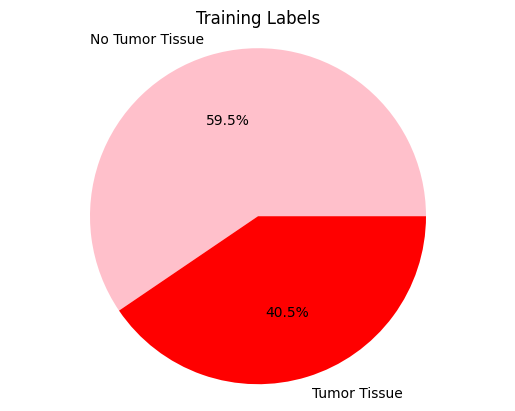

In [42]:
plt.pie(train_df['label'].value_counts(), labels=['No Tumor Tissue', 'Tumor Tissue'], colors=['pink', 'red'], autopct='%1.1f%%')

plt.axis('equal')
plt.title('Training Labels')
plt.show()

In [43]:
train_files = os.listdir(train_dir)
train_files[:5]

['d43c081bafa286f9c1f7e921883f26ceafebc912.tif',
 '092d0eedebce504847715ee046b6ad74b57599b4.tif',
 'b0d2582c6218a8764323fc940b41312282b99bf4.tif',
 '187c99df762f13f99818e5593d4bab4c6577e7e3.tif',
 '7c5270c83837de5a5cbb2dca511559dc39d19d53.tif']

In [44]:
len(train_files)

220025

In [45]:
img_0 = imread(os.path.join(train_dir, train_files[0]))
img_0.shape

(96, 96, 3)

The training dataset contains **220025** examples, with the number of labels matching the number of files under `train`. The image format is TIFF and uses the common `.tif` extension. Images are 96x96 pixels with 3 channels (presumably RGB). Roughly 40% of the training images are labeled positive for cancer.

We can now view a random sampling of the images along with their associated labels. To the untrained eye, it's difficult to determine what might indicate possible cancerous tissue.

In [46]:
def load_image(iid, image_dir=train_dir):
    path = image_dir + iid + '.tif'
    # print(f'Loading {iid} from {path}')
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

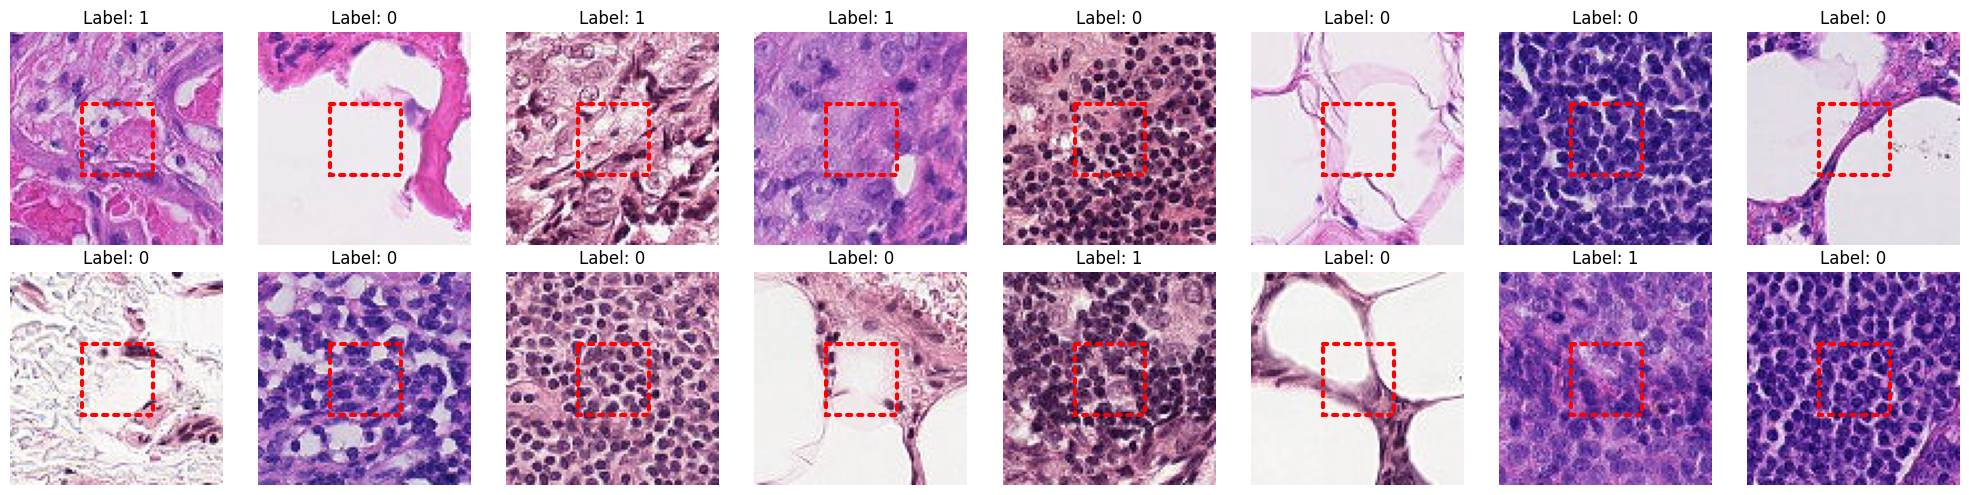

In [48]:
fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(20, 5))
for idx, i in enumerate(np.random.choice(train_df['id'], 16)):
    img = load_image(i)
    ax = axes.flat[idx]
    ax.imshow(img)
    ax.axis('off')
    id = i.split('.')[0]
    l = train_df[train_df.id == id].values[0][1]
    ax.set_title(f'Label: {l}')
    box = patches.Rectangle((32, 32), 32, 32,linewidth=3,edgecolor='r',facecolor='none', linestyle=':',capstyle='round')
    ax.add_patch(box)  

plt.tight_layout()
plt.show()


Finally, we can get a view of RGB mean/std and pixel value distributions. The dataset is large, so we'll take a random subsample, compute the mean/std of each channel, and display a histogram of pixel "strength".

Overall, the mean/std results look reasonable and don't indicate any strange patterns that we may need to investigate, and the strength distribution show that more of the pixel space has non-zero values than not, indicating more image space is filled with something vs. blank.

In [49]:
image_samples = np.array([load_image(id) for id in np.random.choice(train_df['id'], 500)])

Mean pixel values (R,G,B): [179.30271788 140.48752691 178.07862912]
Std pixel values (R,G,B): [61.56047411 72.85536618 55.78964949]


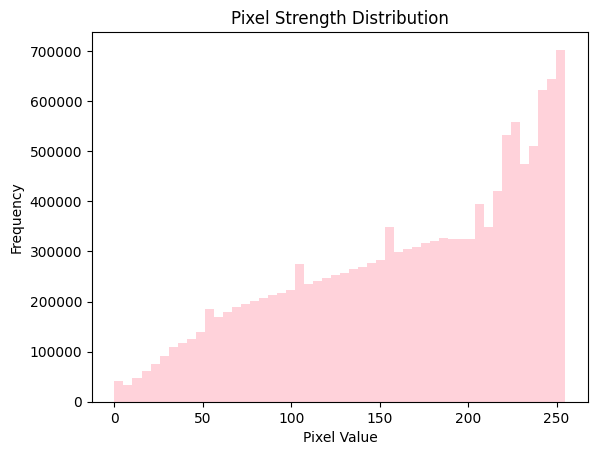

In [50]:
# Get the mean and stddev of pixels per channel (RGB color)
mean_pixel = np.mean(image_samples, axis=(0,1,2))  # Mean per channel
std_pixel = np.std(image_samples, axis=(0,1,2))  # Std deviation per channel

print(f"Mean pixel values (R,G,B): {mean_pixel}")
print(f"Std pixel values (R,G,B): {std_pixel}")

# Histogram of pixel values
plt.hist(image_samples.ravel(), bins=50, color='pink', alpha=0.7)
plt.title("Pixel Strength Distribution")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()


# Modeling/Analysis

We'll now move on to building and training a model.

## Preprocessing

Some preprocessing is necessary to get the data in shape for training. First, we noted above that the dataset is quite large, which could results in very long training runs or OOMs in our relatively small Kaggle session (we only get 30 GiB of RAM) if we were to try to preload all images. To work around this limitation, we'll train on a subset of the full dataset and make sure the positive and negative examples have an even representation.

In [51]:
# Create a smaller dataset with equal number of positive and negative examples.
TRAIN_SIZE_PER_LABEL=10000
negative = train_df[train_df['label'] == 0].sample(TRAIN_SIZE_PER_LABEL)
positive = train_df[train_df['label'] == 1].sample(TRAIN_SIZE_PER_LABEL)
neg_and_pos = pd.concat([negative, positive], axis=0).reset_index(drop=True)
train_df_small = neg_and_pos.sample(frac=1).reset_index(drop=True)  # Shuffles neg_and_pos randomly and resets the row indices


In [54]:
# Create X and y for training based on the smaller dataset.
X = np.array([load_image(i) for i in train_df_small['id']])
y = train_df_small['label'].values

Additional preprocessing will happen as initial layers in the model itself (see below).

## Model Build and Training

The Dataset is ready, so we'll move on to building and training a model.

### Model Preprocessing

Some preprocessing will be completed as initial layers in the model. A positive label means that there is at least one pixel of tumor tissue in the center region (32 x 32px) of the image. Tumor tissue in the outer region of the patch does not influence the label. This means that a negatively labeled image could contain metastases in the outer region. Thus, it would be a good idea to crop the images to the center region. Notably, we'll use `Rescaling` to scale the RGB values between 0 and 255, and `Cropping2D` to only train on the center 32x32px image as specified in the problem.

### Model #1 Architecture

The starting model architecture is relatively simple. After the preprocessing layers, we have three Convolution + MaxPooling layers for encoding, followed by a single fully connected layer funneling down (through a dropout) to the final sigmoid. The Convolution layers progressively increase the number of filters/kernels from 32 to 128.

In [55]:
# First model attempt
m1 = keras.Sequential([
    layers.Input(shape=(96, 96, 3)),
    layers.Rescaling(1./255), # normalize to 0-1 range
    layers.Cropping2D(cropping=32), # crop to center
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])
m1.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', 'auc'])
m1.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)              │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping2d_3 (Cropping2D)            │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 159,041 (621.25 KB)

 Trainable params: 159,041 (621.25 KB)

 Non-trainable params: 0 (0.00 B)

In [57]:
es1 = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
h1 = m1.fit(X, y, validation_split=0.2, epochs=50, callbacks=[es1])

Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8396 - auc: 0.9097 - loss: 0.3834 - val_accuracy: 0.7790 - val_auc: 0.8607 - val_loss: 0.4802
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8414 - auc: 0.9153 - loss: 0.3723 - val_accuracy: 0.7772 - val_auc: 0.8604 - val_loss: 0.4838
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8456 - auc: 0.9182 - loss: 0.3665 - val_accuracy: 0.7793 - val_auc: 0.8609 - val_loss: 0.4883
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8524 - auc: 0.9225 - loss: 0.3578 - val_accuracy: 0.7797 - val_auc: 0.8583 - val_loss: 0.4869
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8567 - auc: 0.9274 - loss: 0.3468 - val_accuracy: 0.7800 - val_auc: 0.8577 - val_loss: 0.4947
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8634 - auc: 0.9325 - loss: 0.3352 - val_accuracy: 0.7725 - val_auc: 0.8571 - val_loss: 0.5068
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 

In [59]:
# Prepare test data for evaluation.
test_files = os.listdir(test_dir)
test_ids = [f.split('.')[0] for f in test_files]
test_X = np.array([load_image(i, image_dir=test_dir) for i in test_ids])

In [67]:
results = m1.predict(test_X)
results = results.reshape(-1)
results.shape
binary_results = (results >= 0.5).astype(int)


1796/1796 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
[0 0 0 ... 1 0 0]


In [68]:
results_df = pd.DataFrame({
    'id': test_ids,
    'label': binary_results.tolist(),
})

In [95]:
# # Uncomment to create submission for Model #1
results_df.to_csv('submission.csv', index=False)
results_df.head()

,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e,0
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,0
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,0
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0,1
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62,1




## Model #2 Architecture

To provide an additional model for comparison, we'll train and submit results from a model with a slightly more complex architecture. Model #2 will be deeper with five Convolution layers, and will add `BatchNormalization` layers after each `Conv2D` to help with stability and potentially increase training efficiency with the larger number of parameters, also adding  `L2 regularization` to potentially help boost validation accuracy. Similar to Model #1, we funnel down through fully connected layers (with dropout during training) to the final sigmoid.

In [90]:
# Second model attempt

reg = keras.regularizers.l2(0.05)

m2 = keras.Sequential([
    layers.Input(shape=(96, 96, 3)),
    layers.Rescaling(1./255),
    layers.Cropping2D(cropping=32),
    
    layers.Conv2D(32, (3,3), padding='same', activation='relu', kernel_regularizer=reg),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_regularizer=reg),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_regularizer=reg),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_regularizer=reg),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_regularizer=reg),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

m2.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy', 'auc'])
m2.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_6 (Rescaling)              │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping2d_6 (Cropping2D)            │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 4, 4, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 4, 4, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 2, 2, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 2, 2, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │          65,6

 Total params: 1,638,337 (6.25 MB)

 Trainable params: 1,636,353 (6.24 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [92]:
es2 = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
h2 = m2.fit(X, y, validation_split=0.2, epochs=30, callbacks=[es2])

Epoch 1/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.6978 - auc: 0.7616 - loss: 27.6859 - val_accuracy: 0.6332 - val_auc: 0.8152 - val_loss: 14.7416
Epoch 2/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7651 - auc: 0.8370 - loss: 11.8281 - val_accuracy: 0.7720 - val_auc: 0.8381 - val_loss: 6.2187
Epoch 3/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7722 - auc: 0.8432 - loss: 5.2081 - val_accuracy: 0.7408 - val_auc: 0.8049 - val_loss: 3.1103
Epoch 4/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7807 - auc: 0.8508 - loss: 2.6521 - val_accuracy: 0.7577 - val_auc: 0.8367 - val_loss: 1.8483
Epoch 5/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7816 - auc: 0.8570 - loss: 1.6586 - val_accuracy: 0.7253 - val_auc: 0.8328 - val_loss: 1.4179
Epoch 6/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7972 - auc: 0.8659 - loss: 1.2279 - val_accuracy: 0.7710 - val_auc: 0.8436 - val_loss: 1.1071
Epoch 7/30
500/500 ━━━━━━━━━━━━━━━━━

In [93]:
results = m2.predict(test_X)
results = results.reshape(-1)
results.shape
binary_results = (results >= 0.5).astype(int)

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


In [73]:
results_df = pd.DataFrame({
    'id': test_ids,
    'label': binary_results.tolist(),
})

In [76]:
# # Uncomment to create submission for Model #2
#results_df.to_csv('submission.csv', index=False)
#results_df.head()

,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e,1
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,0
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,0
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0,1
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62,0


In [77]:
# More Complex Model (Adding more dense layers to see if my training results improve)
reg = keras.regularizers.l2(0.05)

m3 = keras.Sequential([
    layers.Input(shape=(96, 96, 3)),
    layers.Rescaling(1./255),
    layers.Cropping2D(cropping=32),
    
    layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (2,2), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(256, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(512, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid')
])
m3.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', 'auc'])
m3.summary()



Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_5 (Rescaling)              │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping2d_5 (Cropping2D)            │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 16, 16, 64)          │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 4, 4, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 4, 4, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 2, 2, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 2, 2, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 512)                 │              

 Total params: 2,612,929 (9.97 MB)

 Trainable params: 2,610,945 (9.96 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [78]:
es3 = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
h3 = m3.fit(X, y,validation_split=0.2, epochs=30, callbacks=[es3])

Epoch 1/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.6617 - auc: 0.7177 - loss: 0.7658 - val_accuracy: 0.6495 - val_auc: 0.7821 - val_loss: 0.7455
Epoch 2/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7315 - auc: 0.8069 - loss: 0.5527 - val_accuracy: 0.7707 - val_auc: 0.8513 - val_loss: 0.4804
Epoch 3/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7633 - auc: 0.8387 - loss: 0.5013 - val_accuracy: 0.7807 - val_auc: 0.8551 - val_loss: 0.4741
Epoch 4/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7795 - auc: 0.8536 - loss: 0.4776 - val_accuracy: 0.7862 - val_auc: 0.8622 - val_loss: 0.4635
Epoch 5/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7927 - auc: 0.8647 - loss: 0.4593 - val_accuracy: 0.7887 - val_auc: 0.8650 - val_loss: 0.4597
Epoch 6/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8023 - auc: 0.8807 - loss: 0.4318 - val_accuracy: 0.7788 - val_auc: 0.8565 - val_loss: 0.4744
Epoch 7/30
500/500 ━━━━━━━━━━━━━━━━━━━━

In [79]:
results = m3.predict(test_X)
results = results.reshape(-1)
results.shape
binary_results =  (results >= 0.5).astype(int)

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


In [80]:
results_df = pd.DataFrame({
    'id': test_ids,
    'label': binary_results.tolist(),
})

In [81]:
# Uncomment to create submission for Model #3.
#results_df.to_csv('submission.csv', index=False)
#results_df.head()

,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e,0
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,0
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,0
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0,1
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62,1


# Results

Overall, Model #3 scored better than #1 and #2 with a highest validation accuracy at 0.7887. This was using a random, balanced 10k training set.

| Model | Parameters | Kaggle Score |
| -------- | ------- | ------- |
| m1 | 159,041 | 0.7776 |
| m2 | 1,636,353 | 0.7124 |
| m3 | 2,610,945 | 0.7776 |


I tried with more Convo2D layers and the results show that more trainable parameters is not necessarily better as far as performance. A more complex model with a high number of parameters could easily overfit, and the extra training time may not be worth the cost depending on the accuracy requirements of a given problem.

From the training progression graphs below, we can see that Model #1 starts overfitting after approximately 25 epochs, indicated by the divergence of training and validation values across all metrics.

Model #2 appears to converge slightly faster at around 5-6 epochs, with the training/validation metric divergence coming after that. One interesting artifact to note is the validation metrics swinging pretty wildly after 5-6 epochs, possibly indicating a too large learning rate.

Model #3 has a deeper classification layer, which increased trainable parameters by ~1M, which improved the validation accuracy score. The batch normalization helps with faster convergence of the model while the L2 regularization prevents overfitting and maxpooling extracts important features.

Finally, more than doubling the training set size for all model architectures did **not** improve the Kaggle score. This may hint that iterating on hyperparameters and architectures with a smaller training set may be beneficial before training with a larger dataset.

In [88]:
def graph_train_hist(h):
    # Graph of training/validation loss and accuracy.
    loss = h.history['loss']
    val_loss = h.history['val_loss']
    accuracy = h.history['accuracy']
    val_accuracy = h.history['val_accuracy']
    auc = h.history['auc']
    val_auc = h.history['val_auc']
    epochs = range(1, len(loss) + 1)
    
    plt.figure(figsize=(18, 5))
    
    # AUC
    plt.subplot(1, 3, 1)
    plt.plot(epochs, loss, 'r-', label='Training AUC')
    plt.plot(epochs, val_loss, 'b-', label='Validation AUC')
    plt.title('Training and Validation AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()
    
    # Loss
    plt.subplot(1, 3, 2)
    plt.plot(epochs, loss, 'r-', label='Training Loss')
    plt.plot(epochs, val_loss, 'b-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy
    plt.subplot(1, 3, 3)
    plt.plot(epochs, accuracy, 'r-', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'b-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()

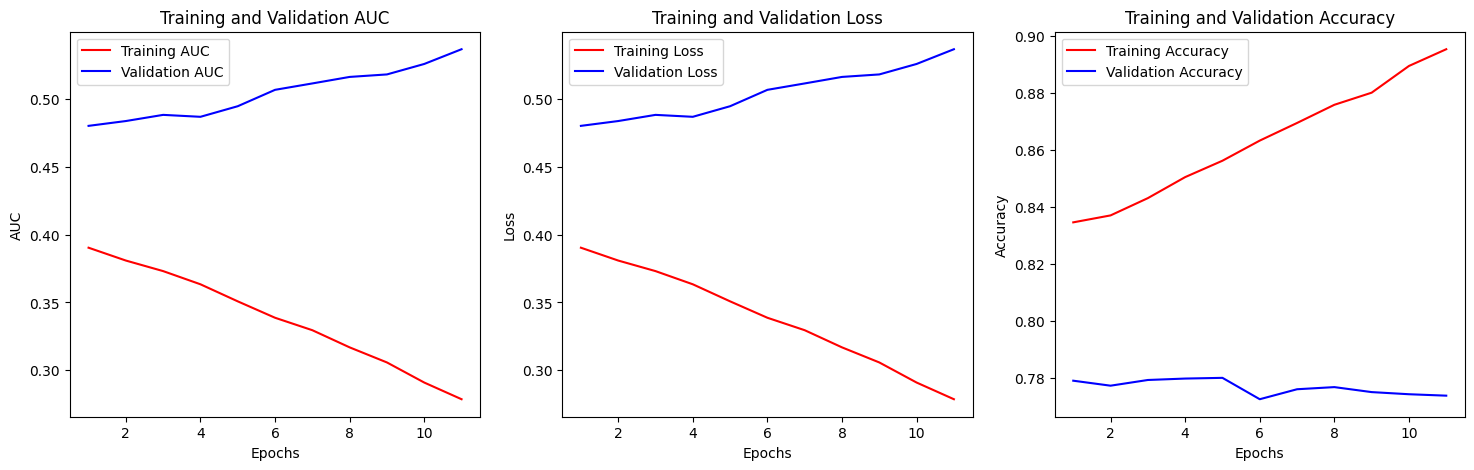

In [89]:
# Model #1 Training results (learning rate 0.001).

graph_train_hist(h1)

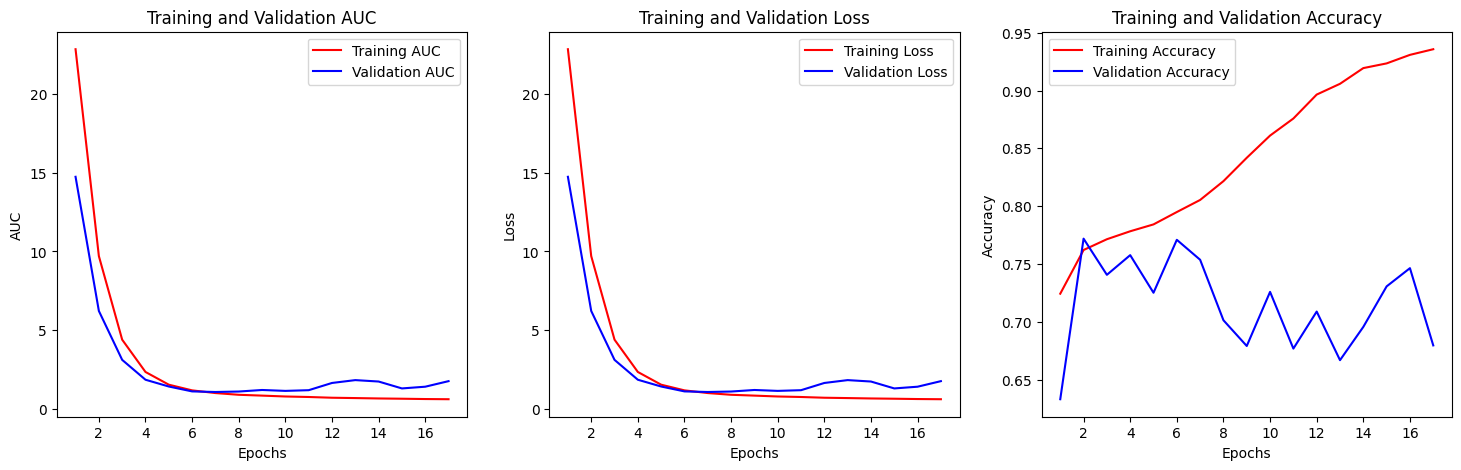

In [94]:
# Model #2 training results (learning rate 0.001).

graph_train_hist(h2)

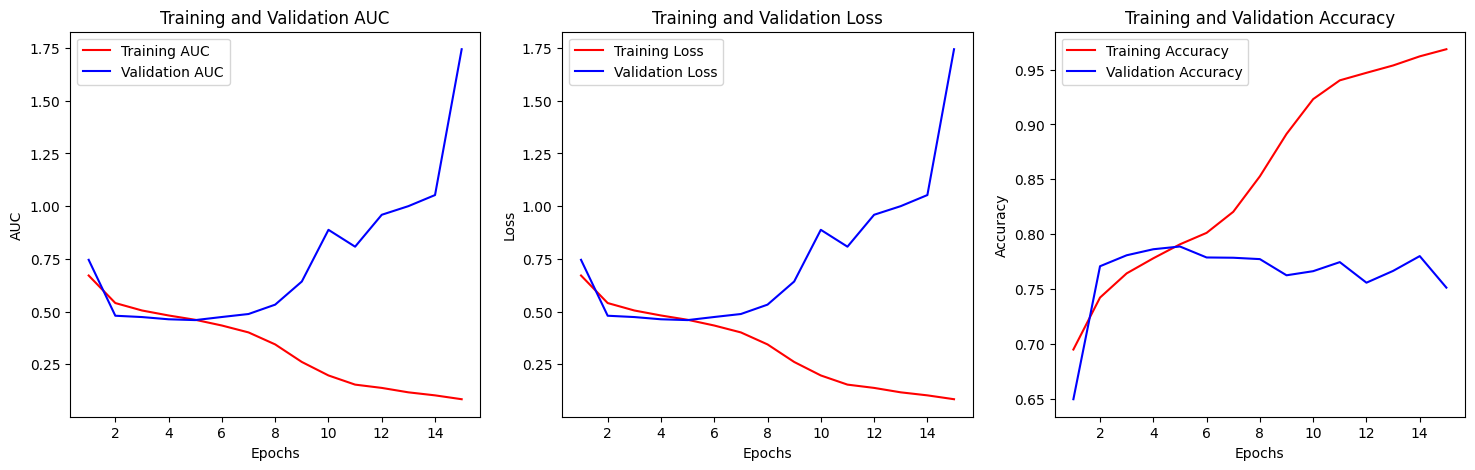

In [85]:
# Model #3 training results (learning rate 0.0001).

graph_train_hist(h3)

# Conclusion

The simple models above performed relatively well given the limitation of training on a subset of the data. We observed that increasing model depth and adding batchnorm layers increased the overall Kaggle score as expected.

Additional performance gains might be achieved with:
* Adding image augmentation layer(s) to artificially increase the training set (e.g., image rotations, skews, etc.)
* Adding dropout layers at each aggregate convolution layer
* Experimenting with different classifiers (e.g., random forest)
* Experimenting with non-default hyperparameters such as strides in the conv layers or momentum in the batchnorm layers
* Using input pipelines to allow training on the full training dataset without OOMs

The possibilities for knobs to tune are wide and varying, but we were able to show relatively good performance using mostly default hyperparameters with pretty generic CNN architectures.

## GitHub

This notbook is available under https://github.com/nehcynnaf/CNN_Tumor_Detection/tree/main